In [1]:
#Add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Load data processed on the HPC

prs = pd.read_csv("../data/protein_prs_cases.csv", sep="\t", index_col=0)

prs.head()

,Group,Case,Sex,C4A.C4B.4481.34.2,IL10.2773.50.2,MMP9.2579.17.5,CSF3.8952.65.3,GC.6581.50.3,APOB.2797.56.2,CFH.4159.130.1,...,C3.2755.8.2,PPY.4588.1.2,IGFBP2.2570.72.5,APOE.2937.10.2,FGA.FGB.FGG.4907.56.1,PLG.3710.49.2,TNF.5936.53.3,ANGPT2.13660.76.3,CRP.4337.49.2,VCAM1.2967.8.1
0,A,2,2,-0.069435,-0.034924,-0.126787,0.351996,0.314848,-0.318171,0.195647,...,0.057947,0.749855,0.146249,-0.133883,-2.490502,-0.324963,-0.978661,0.039893,-0.266216,-0.038887
1,A,2,2,-1.071661,-0.421213,-0.872182,0.101832,-0.296282,0.689710,-0.409555,...,-0.903393,0.306309,-1.152134,0.421410,0.405951,0.950770,1.549364,1.410669,-1.659654,2.214628
2,A,2,1,0.321382,-2.000421,-0.126787,0.207792,0.952631,-2.252077,-1.264962,...,1.754089,1.248028,1.187176,-1.003851,-0.848056,-0.324963,-1.076009,0.381713,-0.420168,-0.413070
3,A,2,2,0.575056,-0.256073,0.618608,-1.863235,-0.379302,0.689710,-0.636036,...,-1.259195,-0.329593,-0.662532,-0.133883,1.754016,0.614542,-1.708552,-1.134225,-1.053209,-0.110263
4,A,2,2,1.512781,0.417969,-0.126787,0.091216,-0.337681,-0.318171,-0.115083,...,0.554612,-0.582945,0.512406,0.843965,0.379672,-1.239034,0.858960,-0.683777,-0.344878,-0.487496


In [3]:
#Update case and sex from 2/1 and to dummy variables 1/0
#Case -> 1 = "AD", 0 = "CTL"
#Sex -> 1 = "Female", 0 = "Male"

if (prs["Case"].max() == 2) | (prs["Sex"].max() == 2):
    prs.loc[prs["Case"] == 1, "Case"] = 0
    prs.loc[prs["Case"] == 2, "Case"] = 1

    prs.loc[prs["Sex"] == 1, "Sex"] = 0
    prs.loc[prs["Sex"] == 2, "Sex"] = 1
else:
    print("Already updated")

print(prs[["Case", "Sex"]].describe())

print(prs.groupby("Group")["Case"].sum())

              Case          Sex
count  6244.000000  6244.000000
mean      0.686579     0.598334
std       0.463921     0.490274
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       1.000000     1.000000
max       1.000000     1.000000
Group
A    3277
B     639
C     371
Name: Case, dtype: int64


In [52]:
#METHOD TO PREPARE RESULTS (ADJUST FOR RANDOM FOREST INPUTS)
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def assess_model_performance(md, pred, X_test, y_test, model_name, plot=True):
    accuracy_sk = md.score(X_test, y_test)
    auc = roc_auc_score(y_test, md.predict(X_test))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    sensitivity = tp / (tp + fn) #-> also recall
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    result = pd.DataFrame({"model_name":model_name, 
                           "accuracy":accuracy_sk, 
                           "sensitivity": sensitivity, 
                           "specificity":specificity,
                           "precision":precision,
                           "auc":auc}, index=[1])
    
    if plot:
        probas = md.predict_proba(X_test)
        plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label=model_name)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(prop={'size':10}, loc='lower right')
    
    return result

Coefficients [[ 4.82561373e-02 -3.94991072e-02 -2.58894179e-02 -2.19497792e-02
   1.01224872e-01  6.85899864e-01 -5.46283801e-02 -4.45607381e-02
   1.11476074e-02  9.75022466e-02 -1.12693398e-01 -6.49660253e-02
  -1.89395029e-02 -4.42602900e-02 -1.94251734e-02 -2.67310898e-02
  -2.96437741e-02  5.83569870e-04  9.80004723e-02 -2.80418393e-02
  -1.60723090e-02  6.73173043e-02  4.47586362e-02 -2.01802350e-02
  -2.09578531e-01  7.86333124e-02 -6.45508597e-02 -2.28776800e-02
  -4.88796643e-02 -5.12216706e-02  3.25271256e-02]]
Coefficients [[ 0.04554592 -0.03670234 -0.02269503 -0.01913046  0.09865416  0.67978201
  -0.05109493 -0.04186287  0.00853492  0.09428959 -0.10966162 -0.06256263
  -0.01615471 -0.04137887 -0.01726666 -0.02316297 -0.02578851  0.
   0.0943599  -0.02477986 -0.01319137  0.06359623  0.0414081  -0.0174039
  -0.20320825  0.07533411 -0.06118315 -0.02039234 -0.04482049 -0.04921775
   0.02898622]]
Coefficients [[ 2.60519595e-02 -1.70073479e-02 -5.24712194e-03 -3.56330431e-03
   6

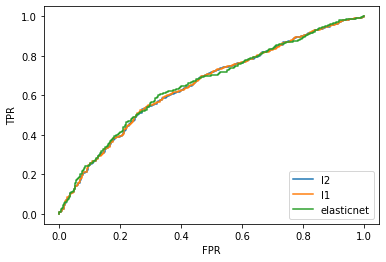

In [53]:
#Test the use of a Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

PROTEIN_DATA = prs.iloc[:, 3:]
#RESULTS = pd.DataFrame()

#Split data into training and hold-out test
x_train, x_test, y_train, y_test = train_test_split(PROTEIN_DATA, prs["Case"], test_size=0.25, random_state=0)

#“auto” -> max_features=sqrt(n_features).
clf = RandomForestClassifier(n_estimators=20)
md = clf.fit(x_train, y_train)

#Print feature importances
print("Feature Importance", md.feature_importances_)

pred = md.predict(x_test)

result = assess_model_performance(md, pred, x_test, y_test, "RF Test 1")

print(result)

# RESULTS = RESULTS.append(result, ignore_index = True)

# RESULTS.sort_values(by="auc", ascending=False, inplace=True)
# print(RESULTS)

#Finding - regularized regression using all PRS does improve auc by 0.001. 
    #Ridge regression ("l2") is optimal method suggesting all protein PRS variables have at least some predictive value. 